In [25]:
using JSON
using MultivariateStats
using RDatasets 
using Distributions
using Random
using PyPlot
using Clustering
using LinearAlgebra


dpath = "../dataset_json/"
apath = "../dataset_artifacts/"

# number of patients
n_patients = 5366
n_states   = 750

750

In [2]:
# looking at single patient file
p1 = JSON.parsefile(dpath * "patient_1.json")

Dict{String,Any} with 8 entries:
  "num_observations" => 74
  "mortality"        => true
  "patient_index"    => 1
  "actions"          => Any[21, 21, 1, 1, 1, 1, 1, 1, 1, 21  …  1, 1, 1, 1, 2, …
  "icuid"            => 200003
  "MAP"              => Any[83, 84.5, 68.2, 69.3333, 70, 73, 66, 68, 71, 72  … …
  "cont_actions"     => Any[Any[0.2245, 0.224, 0, 0, 0, 0, 0, 0, 0, 0.225  …  0…
  "trajectory"       => Any[Any[-0.359482, 0.439907, -1.05909, -0.487919, -0.17…

In [3]:
# trajectory size
size(p1["trajectory"][1])

(49,)

In [4]:
# adding all states for all patients into 
# single array to find clusters
states = []
for i = 1:n_patients
    p     = JSON.parsefile(dpath * "patient_" * string(i) * ".json")
    τ     = p["trajectory"]
    τ_len = size(τ)[1] 
    for j = 1:τ_len
       push!(states, τ[j]) 
    end
end
# form state matrix, columns are 49-vectors of states
S = hcat(states...)
size(S)

(49, 352328)

In [5]:
function shuffle_cols(data)
    n = size(data, 2)
    v = view(shuffle(1:n), 1:n)
    return data[:, v]
end

shuffle_cols (generic function with 1 method)

In [6]:
S = shuffle_cols(S)

49×352328 Array{Float64,2}:
  0.444369   -0.359482    0.444369   …   0.444369    -0.359482    0.444369
 -0.0532353  -0.901947    0.442506      -0.182638    -0.428699   -0.0571054
  0.294139    0.132761   -0.457158       0.132761    -0.0427263  -0.0427263
  0.0937651   0.0146003  -0.345521      -0.125811     0.0677567  -0.0125821
  0.222702   -0.0172859  -0.402714      -0.174301    -0.174301    0.124293
 -0.242061   -0.0557151  -0.474993   …  -0.00912866  -0.195474   -0.335234
 -0.13655    -0.13655    -0.0189222     -0.56654     -0.405947    0.0905629
  0.71309    -0.310497    0.113487      -0.080451    -0.080451   -0.080451
  0.23548     0.469847    0.486858       0.666091     0.602496    0.137608
  0.016716    0.592741    1.12682       -0.285852    -0.251645    0.280845
 -0.832711   -0.128477    0.115707   …  -0.107021    -0.309044    0.210048
 -0.281092    0.0717777   0.378178       0.0717777   -0.281092   -0.616493
 -0.243602    0.3014      0.189048      -0.461657     0.500885    0.

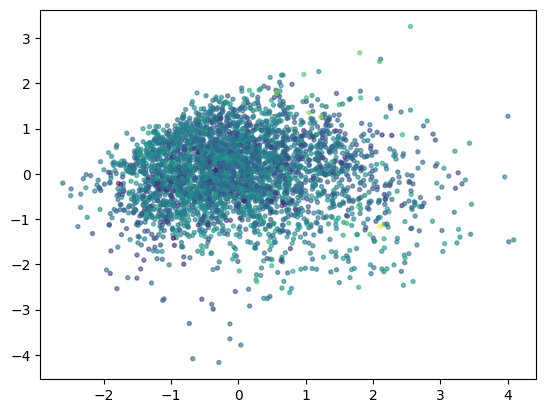

(3, 3524)


In [7]:
# reducing dimentionality of state space for 
# visualization
function partition_dataset(data; at = 0.999)
    n         = size(data, 2)
    idx       = shuffle(1:n)
    
    train_idx = view(idx, 1:floor(Int, at * n))    
    test_idx  = view(idx, (floor(Int, at * n) + 1):n)
    
    return data[:,train_idx], data[:,test_idx]
end

function create_pca_matrix(data; at = 0.999, dims = 3)
    M = fit(PCA, data; maxoutdim = dims)
    return M
end

function reduce_dims(M, data)
    return MultivariateStats.transform(M, data)  
end

M = create_pca_matrix(S, at = 0.998, dims = 3)
_, srs = partition_dataset(S, at = 0.99)
    
# apply PCA model to testing set
y_te = reduce_dims(M, srs)

# reconstruct testing observations (approximately)
# test_2d = reconstruct(M, y_te)
println(size(y_te))
# println(size(test_2d))

scatter(y_te[1,:],y_te[2,:], c = y_te[3,:], s = 8, alpha = 0.6)
plt.show()


In [8]:
function distance(p1, p2, dims)
    d = 0.0
    for i = 1:dims
        d += (p1[i] - p2[i])^2
    end
    return d
end
   
function k_means_pp(data, k)
    dim      = size(data)[1]
    m        = size(data)[2]

    centroids = []
    push!(centroids, data[1:dim, rand(1:m)])

    dist = []
    resize!(dist, m)
    
    for i = 1:(k - 1)
        for s = 1:m
            p = data[:, s]
            d = Float64(Inf)

            for j = 1:size(centroids)[1]
                p_dist = distance(p, centroids[j], dim)
                d = min(d, p_dist)
            end
            dist[s] = d
        end
        
        # add next centroid
        push!(centroids, data[1:dim, argmax(dist)])
    end
    
    return centroids 
end

k_means_pp (generic function with 1 method)

In [9]:
function plot(data, centroids = missing)
    
    scatter(data[1,:], data[2,:], color = "gray")
    
    if !ismissing(centroids)
        scatter(centroids[1,:], centroids[2,:], color = "red")
    end
    
    legend()
    ylim(-50, 50)
    xlim(-50, 50)

    plt.show()
end

plot (generic function with 2 methods)

In [10]:
_, opt = partition_dataset(S, at = 0.95)

println(size(opt))

centroids = k_means_pp(opt, n_states)
println("k-mean-pp init completed")

vc        = hcat(centroids...)
R         = kmeans!(S, vc)

println("vc->")
println(size(vc))
println("<-vc")

M = create_pca_matrix(opt, at = 0.5, dims = 2)

(49, 17617)
k-mean-pp init completed
vc->
(49, 750)
<-vc


PCA(indim = 49, outdim = 2, principalratio = 0.21173393433895943)

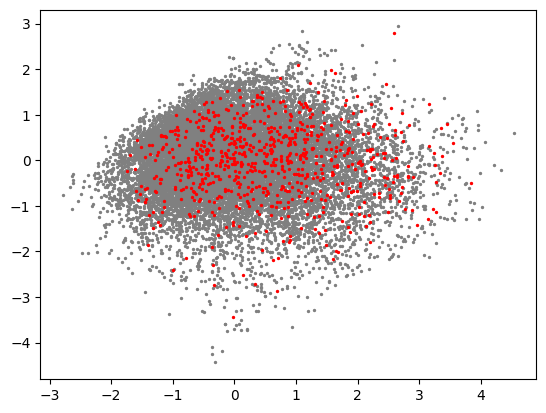

PCA(indim = 49, outdim = 2, principalratio = 0.21173393433895943)
(49, 17617)
(2, 17617)
(49, 750)
(2, 750)


In [11]:
points   = reduce_dims(M, opt)

println(M)
println(size(opt))
println(size(points))

clusters = reduce_dims(M, vc)

println(size(vc))
println(size(clusters))


scatter(points[1,:], points[2,:], color = "gray", s = 2)
scatter(clusters[1,:], clusters[2,:], color = "red", s = 2)
plt.show()

In [12]:
vc

49×750 Array{Float64,2}:
 -0.014052    0.294815   -0.359482   -0.166558   …   0.165407   -0.282283
  0.169452   -0.282965    0.227875   -0.193275      -0.128014    0.062833
 -0.387395    0.423928   -0.0427263   0.143062       0.0571782  -0.0461063
  0.277307    0.114891    0.553472    0.793464       0.113345    0.149288
  0.266909   -0.190427    0.770682    0.837969       0.0458056  -0.00267196
  0.348782    0.117088    0.27039     0.842471   …   0.247841    0.0812746
  0.371347   -0.159294    0.38316     0.512137      -0.0455408   0.200356
 -0.443491    0.257943    0.837272    0.359573      -0.0662384   0.0923567
  0.0849828   0.360368   -1.47475     0.19589        0.16078     0.268892
  0.0933143   0.28423    -1.72938    -0.66721        0.416995   -0.153494
 -0.0667502  -0.171588   -1.86715    -0.856874   …   0.09728    -0.333481
  0.180252    0.316833   -1.03962     0.185251       0.287267   -3.50836e-5
  0.0793339   0.560474    2.38272     0.0699325      0.0750009   0.136528
  ⋮   

In [35]:
function save_state_vectors(filename, clusters)
    json_vc = JSON.json(clusters)
    open(filename, "w") do io
       println(io, json_vc)
    end
end

function restore_state_vectors(filename)
    s = ""
    open(filename, "r") do io
       s = read(io, String)  
    end
    dvc = JSON.parse(s)
    return hcat(dvc...)
end


restore_state_vectors (generic function with 1 method)

In [31]:
state_vectors_file = apath * "state_vectors.json" 
save_state_vectors(state_vectors_file, vc)

In [36]:
lvc = restore_state_vectors(state_vectors_file)

49×750 Array{Float64,2}:
 -0.014052    0.294815   -0.359482   -0.166558   …   0.165407   -0.282283
  0.169452   -0.282965    0.227875   -0.193275      -0.128014    0.062833
 -0.387395    0.423928   -0.0427263   0.143062       0.0571782  -0.0461063
  0.277307    0.114891    0.553472    0.793464       0.113345    0.149288
  0.266909   -0.190427    0.770682    0.837969       0.0458056  -0.00267196
  0.348782    0.117088    0.27039     0.842471   …   0.247841    0.0812746
  0.371347   -0.159294    0.38316     0.512137      -0.0455408   0.200356
 -0.443491    0.257943    0.837272    0.359573      -0.0662384   0.0923567
  0.0849828   0.360368   -1.47475     0.19589        0.16078     0.268892
  0.0933143   0.28423    -1.72938    -0.66721        0.416995   -0.153494
 -0.0667502  -0.171588   -1.86715    -0.856874   …   0.09728    -0.333481
  0.180252    0.316833   -1.03962     0.185251       0.287267   -3.50836e-5
  0.0793339   0.560474    2.38272     0.0699325      0.0750009   0.136528
  ⋮   

In [22]:
dvc

49×750 Array{Float64,2}:
 -0.014052    0.294815   -0.359482   -0.166558   …   0.165407   -0.282283
  0.169452   -0.282965    0.227875   -0.193275      -0.128014    0.062833
 -0.387395    0.423928   -0.0427263   0.143062       0.0571782  -0.0461063
  0.277307    0.114891    0.553472    0.793464       0.113345    0.149288
  0.266909   -0.190427    0.770682    0.837969       0.0458056  -0.00267196
  0.348782    0.117088    0.27039     0.842471   …   0.247841    0.0812746
  0.371347   -0.159294    0.38316     0.512137      -0.0455408   0.200356
 -0.443491    0.257943    0.837272    0.359573      -0.0662384   0.0923567
  0.0849828   0.360368   -1.47475     0.19589        0.16078     0.268892
  0.0933143   0.28423    -1.72938    -0.66721        0.416995   -0.153494
 -0.0667502  -0.171588   -1.86715    -0.856874   …   0.09728    -0.333481
  0.180252    0.316833   -1.03962     0.185251       0.287267   -3.50836e-5
  0.0793339   0.560474    2.38272     0.0699325      0.0750009   0.136528
  ⋮   